Ejercicio 5:


In [ ]:
#Esto convierte el video a un formato más liviano de trabajo
!ffmpeg -y -i VID_20240408_161741~3.mp4 -vf "scale=600:-1" -an -t 30 Video_2.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!pip install -q mediapy
import mediapy as media
url = 'Video_2.mp4'
video = media.read_video(url)
media.show_video(video)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [ ]:
import mediapy as media  # Importar la biblioteca mediapy para manejo de medios
import cv2  # Importar OpenCV para el procesamiento de imágenes y videos
import numpy as np


# Función para oscurecer una imagen:
def process_image(new_image, prev_image, **kwargs):
    # Convertir la imagen a float32
    new_image_float = new_image.astype(np.float32)

    # Reducir el brillo de la imagen a la mitad
    new_image_float *= 0.5

    # Convertir la imagen de vuelta a uint8
    new_image_uint8 = np.clip(new_image_float, 0, 255).astype(np.uint8)

    return new_image_uint8

def draw_contours(frame, contours, color=(0, 255, 0), thickness=2):
    # Comprobar si la imagen es en escala de grises (1 canal)
    if len(frame.shape) == 2 or frame.shape[2] == 1:
        # Convertir la imagen de escala de grises a color (3 canales)
        result_image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        # Si ya es una imagen de color, simplemente hacer una copia
        result_image = frame.copy()

    # Dibujar cada contorno en la imagen
    for contour in contours:
        # Obtener el rectángulo delimitador para cada contorno
        x, y, w, h = cv2.boundingRect(contour)
        # Dibujar el rectángulo
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, thickness)

    return result_image

# Función para procesar un video:
def video_processor(filename_in, filename_out, process_func, max_time=10, **kwargs):
    # Abrir el video de entrada para lectura
    with media.VideoReader(filename_in) as r:
        # Crear un archivo de video de salida
        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:
            count = 0  # Inicializar contador de fotogramas
            prev_image = None  # Inicializar la imagen previa

            # Iterar sobre cada imagen (fotograma) del video
            for image in r:
                new_image = media.to_uint8(image)  # Convertir la imagen a formato flotante

                # Comprobar si es la primera imagen
                if prev_image is None:
                    prev_image = new_image.copy()

                # Procesar la imagen utilizando la función dada
                processed_image = process_func(new_image, prev_image, **kwargs)

                # Añadir la imagen procesada al video de salida
                w.add_image(processed_image)

                # Actualizar la imagen previa
                prev_image = new_image.copy()

                # Incrementar el contador de fotogramas
                count += 1

                # Detener el proceso si se alcanza el tiempo máximo
                if count >= max_time * r.fps:
                    break

# Nombres de los archivos de video de entrada y salida
filename_in = 'Video_2.mp4'
filename_out = 'patio_dark.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_image, 10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)


En el siguiente codigo hice algunas modificaciones para que consiga detectarme de mejor manera pero sigue habiendo un poco de ruido debido al movimiento del fondo.

In [ ]:
import numpy as np

# Función actualizada para realizar diferencia de fotogramas con normalización:
def process_frame_difference_full(new_image, prev_image, **kwargs):
    # Convertir las imágenes a escala de grises
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    # Calcular la diferencia absoluta entre los fotogramas actual y anterior
    frame_diff = cv2.absdiff(new_gray, prev_gray)

    # Normalizar la imagen de diferencia
    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)

    # Umbralizar la imagen para resaltar las diferencias
    _, thresh = cv2.threshold(norm_diff, 30, 255, cv2.THRESH_BINARY)

    # Dilatar la imagen umbralizada para mejorar la detección de contornos
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    # Convertir la imagen dilatada a formato adecuado para findContours
    dilated = dilated.astype(np.uint8)

    # Encontrar contornos en la imagen dilatada
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = kwargs.get('min_area', 5000)
    contours_filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    if kwargs.get('draw_mode', 0) == 0:
        result_image = draw_contours(new_image, contours_filtered)
    elif kwargs.get('draw_mode', 0) == 1:
        result_image = draw_contours(thresh, contours_filtered)

    return result_image
# Nombres de los archivos de video de entrada y salida
filename_in = 'Video_2.mp4'
filename_out = 'patio_frame_difference.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_frame_difference_full, 10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

FLUJO OPTICO DISPERSO

In [ ]:
feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
def process_sparse_optical_flow(new_image, prev_image):
    # Preparamos las imagenes de trabajo
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    prev_gray_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)

    # Verificar si ya se han detectado las características de Shi-Tomasi
    if not hasattr(process_sparse_optical_flow, "shi_tomasi_done"):
        # Definir parámetros para la detección de esquinas de Shi-Tomasi

        # Detectar puntos característicos en la imagen
        process_sparse_optical_flow.prev_points = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params)
        # Crear una máscara para dibujar el flujo óptico
        process_sparse_optical_flow.mask = np.zeros_like(new_image)
        # Marcar que se ha completado la detección de Shi-Tomasi
        process_sparse_optical_flow.shi_tomasi_done = True

    # Continuar si se ha completado la detección de Shi-Tomasi
    if process_sparse_optical_flow.shi_tomasi_done:
        prev_points = process_sparse_optical_flow.prev_points
        mask = process_sparse_optical_flow.mask

    # Parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Calcular el flujo óptico de Lucas-Kanade
    new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # Filtrar puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # Color para el dibujo
    # Dibujar el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        new_image = cv2.circle(new_image, (a, b), 3, color, -1)

    # Combinar la imagen actual con las líneas de flujo óptico dibujadas
    output = cv2.add(new_image, mask)
    # Actualizar puntos para el siguiente cuadro
    process_sparse_optical_flow.prev_points = good_new.reshape(-1, 1, 2)
    return output
# Nombres de los archivos de video de entrada y salida
filename_in = 'Video_2.mp4'
filename_out = 'patio_process_sparse_optical_flow.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_sparse_optical_flow,
                max_time=10)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

FLUJO OPTICO DENSO

In [ ]:
# Función para procesar el flujo óptico denso
def process_dense_optical_flow(new_image, prev_image):
    # Convierte la nueva imagen a escala de grises
    gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

    if not hasattr(process_dense_optical_flow, "init_done"):
        process_dense_optical_flow.prev_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        process_dense_optical_flow.mask = np.zeros_like(new_image)
        process_dense_optical_flow.mask[..., 1] = 255
        process_dense_optical_flow.init_done = True

    if process_dense_optical_flow.init_done:
        prev_gray = process_dense_optical_flow.prev_gray
        mask = process_dense_optical_flow.mask

    # Calcula el flujo óptico
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computa magnitud y ángulo de los vectores 2D
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Establece el tono de la imagen según la dirección del flujo óptico
    mask[..., 0] = angle * 180 / np.pi / 2
    # Establece el valor de la imagen según la magnitud del flujo óptico
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convierte de HSV a RGB
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    # Actualiza la imagen previa a gris
    process_dense_optical_flow.prev_grayprev_gray = gray.copy()
    return rgb

# Nombres de los archivos de video de entrada y salida
filename_in = 'Video_2.mp4'
filename_out = 'patio_process_dense_optical_flow.mp4'

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, process_dense_optical_flow,
                max_time=20)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)

Reflexion: <br>
Se puede ver como el resultado no es perfecto ya que si bien no hay mucho movimiento de fondo, el leve movimiento de las plantas hace que el flujo optico tenga mas ruido. <br>
Pero en el flujo optico disperso se puede ver como si se ve que lo unico que se mueve mucho soy yo.

Ejercicio 6: <br>
La diferencia principal a la localizacion de objetos y la clasificacion de imagenes es que el localizador me va a decir en que parte de la imagen o del video esta el objeto y el clasificador me va a decir que objeto es, pero no donde esta en la imagen. <br>
Ejemplos: <br>
*Localizador: Un sistema de seguridad que identifica y rastrea personas en un edificio.<br>
*Clasificador: Un sistema que dada una foto de un perro te clasifique que raza es

CLASIFICADOR:

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
import cv2

# Cargar el modelo preentrenado EfficientNetB0
model = EfficientNetB0(weights='imagenet')

def classify_image(img_path):
    # Cargar y preparar la imagen
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img,(224, 224))  # Tamaño de entrada para EfficientNetB0

    # Convertir la imagen a un array y procesarla
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Realizar la predicción con el modelo
    predictions = model.predict(img_array)

    # Decodificar y retornar las predicciones
    return decode_predictions(predictions, top=3)[0]

In [19]:
img_path = 'Perrito.png'  # Reemplaza con la ruta de tu imagen
predictions = classify_image(img_path)

print('\n')

# Mostrar las predicciones
for i, (imagenet_id, label, score) in enumerate(predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

35363/35363 [==============================] - 0s 0us/step


1: kuvasz (0.49)
2: golden_retriever (0.25)
3: Great_Pyrenees (0.08)


LOCALIZACION:

In [22]:
%pip install ultralytics
# Librería mediapy para mostrar videos
%pip install -q mediapy
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/107.7 GB disk)



0: 640x480 1 scissors, 436.7ms
Speed: 7.3ms preprocess, 436.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


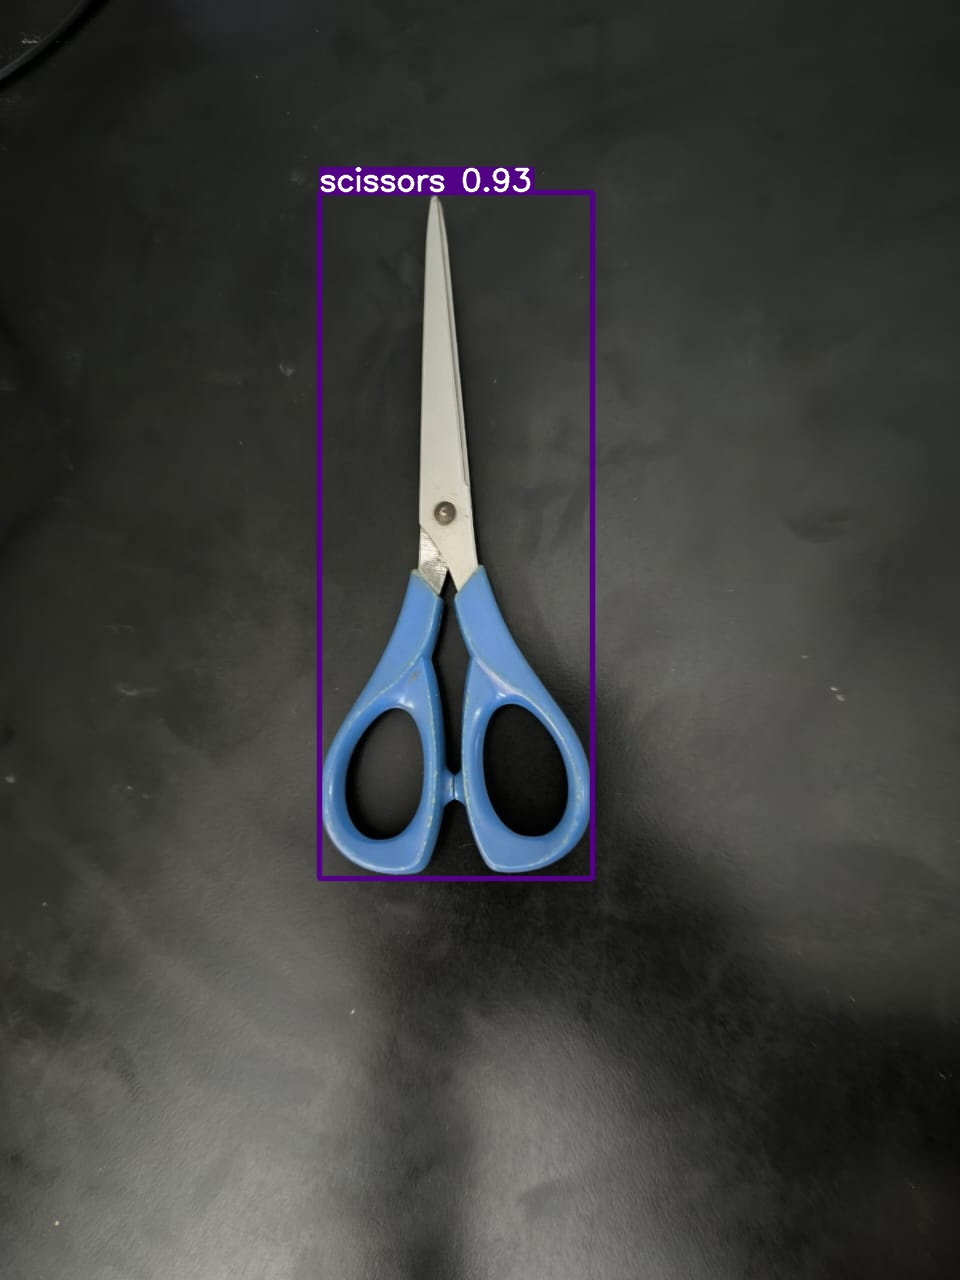

In [24]:
import cv2
from ultralytics import YOLO
from IPython.display import Image

# Load the pre-trained YOLOv8 model
model = YOLO('yolov8n')  # This will automatically download the model weights

# Perform inference
source_img = cv2.imread('/content/Tijera.jpeg')
results = model(source_img)

# Visualize the results on the frame
annotated_frame = results[0].plot()

# Guardamos el resultado en JPG
cv2.imwrite('tijera_results.jpg', annotated_frame)

# Mostramos el resultado en Colab
Image('tijera_results.jpg')